# Optimization of a State-to-State Transfer in a Two-Level-System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
#%load_ext autoreload
#%autoreload 2
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import os
from scipy.signal import savgol_filter
%watermark -v --iversions
π = np.pi
sqrt = np.sqrt
basis = qutip.basis
tensor = qutip.tensor
coherent = qutip.coherent

scipy            1.2.0
qutip            4.3.1
matplotlib.pylab 1.15.4
krotov           0.3.0
matplotlib       3.0.2
numpy            1.15.4
CPython 3.7.2
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$
The purpose of this example is not to solve an especially interesting physical
problem but to give a rather simple example of how the package can be used in
order to solve an optimization problem.

## Define the Hamiltonian

In the
following the Hamiltonian, guess field and
states are defined.

The Hamiltonian
$\op{H}_{0} = - \omega \op{\sigma}_{z}$
represents a
simple qubit with energy
level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control
field
$\epsilon(t)$ is assumed to couple via
the
Hamiltonian $\op{H}_{1}(t) =
\epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control
field effectively
drives
transitions between both qubit
states. For now, we initialize the control
field as constant.

In [3]:
L = 3

# Plotting functions

In [4]:
def to_two_level(state):
    if state.type is 'oper':
        return qutip.Qobj(state[0:2,0:2])
    else:
        return qutip.Qobj(state[0:2])

def plot_population(n, tlist):
    fig, ax = plt.subplots()
    leg = []
    for i in range(len(n)):
        ax.plot(tlist, n[i], label=str(i))
        leg.append(str(i))
    ax.legend()
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Occupation')
    ax.legend(leg)
    plt.show(fig)

def plot_pulse(pulse, tlist, T=None):
    fig, ax = plt.subplots(figsize=(15,4))
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    if np.any(np.iscomplex(pulse)):
        ax.plot(tlist, np.real(pulse))
        ax.plot(tlist, np.imag(pulse))
        ax.legend(['Re', 'Im'])
    else:
        ax.plot(tlist, pulse)
    if T is not None:
        ax.plot(tlist, [S(t, T)*amp_max for t in tlist], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Pulse amplitude')
    plt.show(fig)

def plot_system(ψ):
    bl = qutip.Bloch()
    bl.add_states(to_two_level(ψ.ptrace(0)))
    bl.show()
    qutip.visualization.plot_wigner_fock_distribution(to_two_level(ψ.ptrace(1)))
def plot_resonator(ψ):
    fig, ax = plt.subplots(1,len(ψ), figsize=(3*len(ψ),3))
    if len(ψ)<=1:
        ψ = ψ[0]
        axis = ax
        qutip.visualization.plot_wigner(ψ.ptrace(1), fig=fig, ax=axis, alpha_max = 2*α)
        axis.axis_equal = True
    else:
        for (ϕ, axis) in zip(ψ, ax):
            qutip.visualization.plot_wigner(ϕ.ptrace(1), fig=fig, ax=axis, alpha_max = 2*α)
            axis.axis_equal = True
        
def plot_cardinal(ψ):
    bl = qutip.Bloch()
    bl.vector_color = ['r','g','b','g','b','r']
    [bl.add_states(to_two_level(ϕ.ptrace(0)), 'vector') for ϕ in ψ]
    bl.show()

def plot_all(dyn, ψ):
    ψ_i = [g.states[0] for g in dyn]
    ψ_f = [g.states[-1] for g in dyn]
    ψ_t = [ϕ[1] for ϕ in ψ]
    plot_cardinal(ψ_i)
    plot_resonator(ψ_i)
    plot_cardinal(ψ_t)
    plot_resonator(ψ_t)
    plot_cardinal(ψ_f)
    plot_resonator(ψ_f)
def plot_evolution(dyn, steps=1):
    for d in dyn:
        points = [to_two_level(s) for s in d.states[0:-1:steps]]
        bl = qutip.Bloch()
        bl.vector_color = 'r'
        bl.point_color = 'r'
        bl.point_marker = 'o'
        bl.add_states(points, 'point')
        bl.show()
        bl = qutip.Bloch()
        bl.vector_color = 'r'
        bl.point_color = 'r'
        bl.point_marker = 'o'
        bl.view = [bl.view[0], 80]
        bl.add_states(points, 'point')
        bl.show()

In [5]:
def fid(result, target):
    return (np.abs((result.states[-1].dag()*target).full())**2)[0][0]
def proj(ψ, ϕ=None):
    if ϕ is None:
        return ψ * ψ.dag()
    else:
        return ψ * ϕ.dag()

In [7]:
σ = 3

In [51]:
Si = qutip.operators.identity(L)
ZERO = qutip.operators.qzero(L)

σ_z = proj(qutip.basis(L, 0)) - proj(qutip.basis(L, 1))
σ_y = 1j*(proj(qutip.basis(L, 1),qutip.basis(L, 0)) - proj(qutip.basis(L, 0), qutip.basis(L, 1)))
σ_x = proj(qutip.basis(L, 0),qutip.basis(L, 1)) - proj(qutip.basis(L, 1), qutip.basis(L, 0))
b = qutip.operators.destroy(L)
#b = proj(qutip.basis(L, 0),qutip.basis(L, 1))
I = Si

ω_r = 8.3056 * 2 * π      # resonator frequency
ω_q = 6.2815 * 2 * π      # qubit frequency
K_q   = -2*π*297e-2    # Kerr qubit 200-300 MHz
use_rotating = True
def hamiltonian(ω=1.0, ampl0=1, use_rotating=True, pulses=None, tlist=None, start_pulse=None, T=1, phase=0, σ=σ):
    """Two-level-system Hamiltonian
    
    Args:
        ω (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    
    K_r   = 2*π*0.45e-3   # Kerr res
    #K_q   = -2*π*297e-3    # Kerr qubit 200-300 MHz
    ω_r = 8.3056 * 2 * π      # resonator frequency
    ω_q = 6.2815 * 2 * π      # qubit frequency
    χ = 0.025 * 2 * π   # parameter in the dispersive hamiltonian

    Δ = abs(ω_r - ω_q)    # detuning
    g = sqrt(Δ * χ)  # coupling strength that is consistent with chi
    γ = 1e1
    
    #H_occ = w_r*a.dag()*a + w_q*b.dag()*b
    if L==3:
        H_occ_q = qutip.Qobj(np.diag([0, ω_q, 2*ω_q]))
    else:
        H_occ_q = qutip.Qobj(np.diag([0, ω_q]))
    #H_occ_r = ω_r * a.dag()*a
    H_occ =  H_occ_q#  + H_occ_r
    
    
    use_dispersive = True
    use_kerr = True
    #if use_dispersive:
    #    #H_coup = - chi_qr * a.dag()*a * b.dag()*b
    #    H_coup =  χ * (a.dag()*a + I/2) * σ_z
    #else:
        #H_coup = g * (a.dag() * b + a * b.dag())
    #    H_coup = g * σ_x *a.dag() + a
    if use_kerr:
        H_kerr = - K_q/2 * b.dag()**2 * b**2
    else:
        H_kerr = ZERO
    
    H_d = ZERO
    
    if use_rotating:
        H_d += H_kerr
        
        H_qr = (b.dag() + b)
        H_qi = 1j*(b.dag() - b)
        #H_rr = (a + a.dag())
        #H_ri = 1j*(a.dag() - a)
        
        if start_pulse is None:
            ϵ_qr = lambda t, args: ampl0
            ϵ_qi = lambda t, args: ampl0
        else:
            ϵ_qr = shape_field(lambda t, args: ampl0, start_pulse, T, σ)
            ϵ_qi = shape_field(lambda t, args: ampl0, start_pulse, T, σ)
        #ϵ_rr = lambda t, args: ampl0
        #ϵ_ri = lambda t, args: ampl0
        
        # Random pulses (doesn't really work)
        #ϵ = lambda t, tlist, R: R[np.where(tlist<=t)[0][-1]]
        #O = np.random.rand(len(tlist))
        #ϵ_qr = lambda t, args: ϵ(t, tlist, O)
        #O = np.random.rand(len(tlist))
        #ϵ_qi = lambda t, args: ϵ(t, tlist, O)
        
        
        if pulses:
            ϵ_qr = pulses[0]
            ϵ_qi = pulses[1]
        #    ϵ_rr = np.zeros(len(pulses[0]))
        #    ϵ_ri = np.zeros(len(pulses[0]))

        return [H_d, [H_qr, ϵ_qr], [H_qi, ϵ_qi]]#, [H_rr, ϵ_rr], [H_ri, ϵ_ri]]
    else:
        H_d += H_occ + H_kerr#+ H_coup
        
        H_q = b
        H_qc = b.dag()
        #H_rr = ZERO
        #H_ri = ZERO
        

        ϵ_q = lambda t, args: 1j*ampl0*np.exp(1j*ω_q*t)
        ϵ_qc = lambda t, args: -1j*ampl0*np.exp(-1j*ω_q*t)
        #ϵ_rr = lambda t, args: ampl0
        #ϵ_ri = lambda t, args: ampl0
        
        if pulses:
            ϵ_q = pulses[0]
            ϵ_qc = pulses[1]
            #ϵ_rr = np.zeros(len(pulses[0]))
            #ϵ_ri = np.zeros(len(pulses[0]))
        
        return [H_d, [H_q, ϵ_q], [H_qc, ϵ_qc]]#, [H_rr, ϵ_rr], [H_ri, ϵ_ri]]

def coeffs_to_state(c,init = True):
    if init:
        ψ = tensor((c[0]*basis(L,0) + c[1]*basis(L,1)).unit() , (basis(N,0)))
    else:
        ψ = tensor((basis(L,0)) , (c[0]*cat_0 + c[1]*cat_1).unit())
    return ψ

def states(coeffs):
    return [[coeffs_to_state(c,True),coeffs_to_state(c,False)] for c in coeffs]

## Define the optimization target

First we define the time grid of the
dynamics, i.e., by taking the following
values as an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=5$. The entire time grid is divided into
$n_{t}=500$ equidistant time steps.

In [52]:
σ = 3 # ns (gaussian pulse limit)
A = 1.5624613041 # Chosen such that the integral of any Blackman pulse = π/2
amp_max = A/(np.sqrt(2*π)*σ)

T_q = (2*π)/ω_q
T = 0.5 * T_q
T = 6*σ
steps = 2000
tlist = np.linspace(0, T, steps)


H = hamiltonian(ampl0=1, use_rotating=True, phase=np.exp(-1j*ω_q*T))
#coeffs = [(1,0), (1,-1), (1,1j), (1,1), (1,-1j), (0,1)]
#st = states(coeffs)
#ϕ = [[ tensor(basis(L,0), coherent(N,α)), tensor((basis(L,0)-basis(L,1)).unit(), coherent(N,α)) ]]
#ϕ = [[ basis(L,0), (basis(L,0)-basis(L,1)).unit() ]]
ϕ = [[ basis(L,0), basis(L,1) ]]
F_err = 1e-6
F_oc_tar = 1-F_err

Next, we define the optimization targets, which is technically a list of
objectives, but here it has just one entry defining a simple state-to-state
transfer
from initial state $\ket{\Psi_{\init}} = \ket{0}$ to the target state
$\ket{\Psi_{\tgt}} = \ket{1}$, which we want to reach at final time $T$. Note
that we also have to pass the Hamiltonian $\op{H}(t)$ that determines the
dynamics of
the system to the optimization objective.

In [53]:
import copy
def state_rot(ϕ, T):
    ϕ = copy.deepcopy(ϕ)
    if np.sum(np.array(ϕ[0][1].full())==0) != L-1:
        if L == 3:
            rot_evo = qutip.Qobj([[1, 0, 0],[0, np.exp(-1j * ω_q * T), 0],[0, 0, 0]])
        else:
            rot_evo = qutip.Qobj([[1, 0],[0, np.exp(-1j * ω_q * T)]])
        
        ϕ[0][1] = rot_evo * ϕ[0][1]
    return ϕ

if use_rotating:
    objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in state_rot(copy.deepcopy(ϕ), T)]
else:
    objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in ϕ]

In addition, we have to define and assign a shape function $S(t)$ for the update
in each control iteration to each
control field that will be updated. This shape
usually takes care of
experimental limits such as the necessity of finite ramps
at the beginning and
end of the control field or other conceivable limitations
for field shapes: wherever $S(t)$ is zero, the optimization will not change the
value of the control from the original guess.

At this point, we also change the initial control field $\epsilon_{0}(t)$ from a
constant to a shaped pulse that switches on smoothly from zero and again
switches off at the final time $T$. We re-use the shape function $S(t)$ that we
defined for the updates for this purpose (although generally, $S(t)$ for the
updates has nothing to with the shape of the control field).

In [54]:
def S(t, T=6*σ, σ=σ):
    rise_time = 3*σ
    if T<rise_time*2:
        if t<=T/2:
            return krotov.shapes.flattop(t, t_start=0, t_stop=rise_time*2, t_rise=rise_time, t_fall=rise_time, func='sinsq')
        else:
            return krotov.shapes.flattop(t+rise_time*2-T, t_start=0, t_stop=rise_time*2, t_rise=rise_time, t_fall=rise_time, func='sinsq')
    else:
        return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=rise_time, t_fall=rise_time, func='sinsq')

def start_pulse(t, T=6*σ, σ=σ):
    if σ is not None:
        return amp_max*krotov.shapes.blackman(t, t_start=0, t_stop=6*σ)
    else:
        return krotov.shapes.blackman(t, t_start=0, t_stop=T)
def zero_pulse(t, T=T, σ=4):
    return 0
def unit_pulse(t, T=T, σ=4):
    return amp_max

def shape_field(ϵ, sf, T, σ):
    """Applies the shape function S(t) to the guess field"""
    ϵ_shaped = lambda t, args: ϵ(t, args)*sf(t, T=T, σ=σ)
    return ϵ_shaped

S_start = [unit_pulse,unit_pulse]
S_funs = [S,S]
for i, H_i in enumerate(H[1:]):
    H_i[1] = shape_field(H_i[1], S_start[i], T, σ)
#for i, H_i in enumerate(H[1:]):
#    H_i[1] = shape_field(H_i[1], S_funs[i], T, σ)


Having defined the shape function $S(t)$ and having shaped the guess field, we
now tell the optimization to also use $S(t)$ as the update-shape for
$\epsilon_0(t)$. In addition, we have to choose `lambda_a` for each control
field. It controls the update magnitude of the respective field in each
iteration.

It is convenient to introduce the function `print_fidelity`, which can be passed
to the optimization procedure and will be called after each iteration and thus
provides additional feedback about the optimization progress.

## Simulate dynamics of the guess field

Before heading towards the optimization
procedure, we first simulate the
dynamics under the guess field
$\epsilon_{0}(t)$.

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen
above, just a constant field (with a smooth switch-on and switch-off)

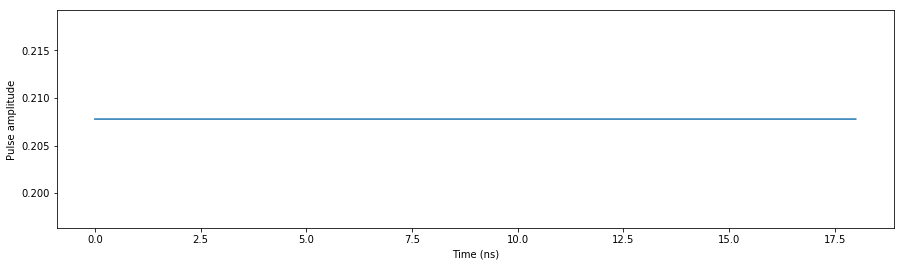

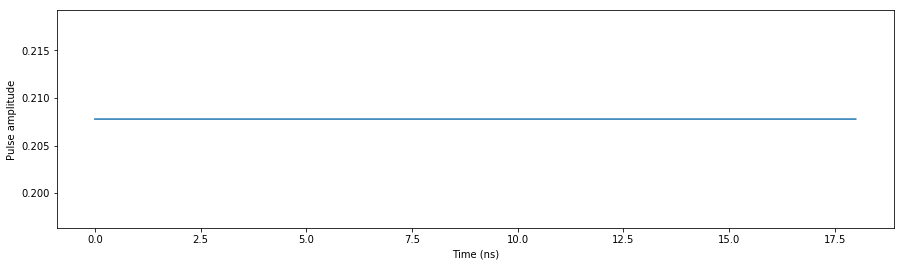

In [56]:
for H_i in H[1:]:
    plot_pulse(H_i[1], tlist)

The next line solves the equation of motion for the defined objective, which
contains the initial state $\ket{\Psi_{\init}}$ and the Hamiltonian $\op{H}(t)$
defining its evolution.

In [57]:
guess_dynamics = [ob.mesolve(tlist, progress_bar=True, options=qutip.Options(nsteps=50000)) for ob in objectives]

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.32s. Est. time left: 00:00:00:00
40.0%. Run time:   0.42s. Est. time left: 00:00:00:00
50.0%. Run time:   0.52s. Est. time left: 00:00:00:00
60.0%. Run time:   0.62s. Est. time left: 00:00:00:00
70.0%. Run time:   0.73s. Est. time left: 00:00:00:00
80.0%. Run time:   0.84s. Est. time left: 00:00:00:00
90.0%. Run time:   0.95s. Est. time left: 00:00:00:00
Total run time:   1.05s


In [58]:
def qubit_occupation(dyn):
    occ = [basis(L,i)*basis(L,i).dag() for i in range(0,L)]
    n = qutip.expect(occ, dyn.states)
    plot_population(n, dyn.times)

def plot_norm(result):
    state_norm = lambda i: result.states[i].norm()
    states_norm=np.vectorize(state_norm)

    fig, ax = plt.subplots()
    ax.plot(result.times, states_norm(np.arange(len(result.states))))
    ax.set_title('Norm loss', fontsize = 15)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('State norm')
    plt.show(fig)

In [59]:
#state_1 = basis(3,1)
#state_2 = ((0.15643447-0.98768834j)*basis(3,1)).unit()
#qutip.visualization.matrix_histogram(state_1 * state_2.dag(), limits=[0,1])
#qutip.visualization.matrix_histogram_complex(state_1 * state_2.dag(), limits=[0,1])


#plot_cardinal([to_two_level(state_1),to_two_level(state_2)])

In [60]:
def desuperposition(ϕ, f):
    ϕ_f = copy.deepcopy(ϕ)
    for (i, s) in enumerate(ϕ_f.full()):
        if np.abs(s)[0] < f:
            ϕ_f.data[i] = 0
    ϕ_f = ϕ_f.unit()
    for (i, s) in enumerate(ϕ_f.full()):
        if np.abs(s)[0] == 1:
            ϕ_f.data[i] = 1
    return ϕ_f

Fidelity: 0.7027139839770256


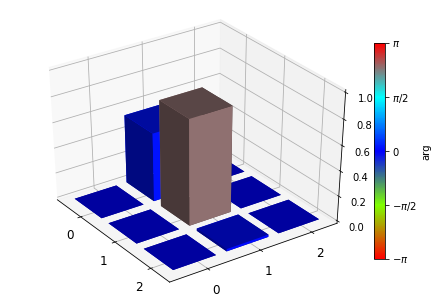

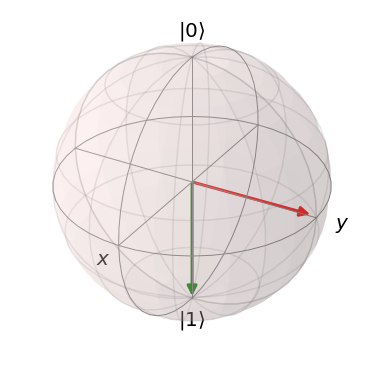

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.54177433+0.05845743j]
 [-0.64000514+0.54139395j]
 [ 0.01866103+0.00104013j]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]


In [61]:
final_state = desuperposition(guess_dynamics[0].states[-1], F_err)

dm = final_state * ϕ[0][1].dag()
fid = np.abs((final_state.dag() * ϕ[0][1]).full()[0][0])**2
print('Fidelity: {}'.format(fid))
qutip.visualization.matrix_histogram_complex(dm, limits=[0,1])
plot_cardinal([final_state,ϕ[0][1]])
print(final_state)
print(ϕ[0][1])

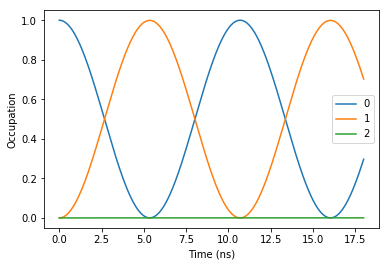

In [62]:
qubit_occupation(guess_dynamics[0])
#plot_norm(guess_dynamics[0])

The plot of the population dynamics shows that the guess field does not transfer
the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target state
$\ket{\Psi_{\tgt}} = \ket{1}$.

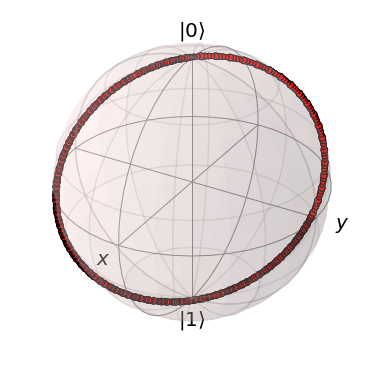

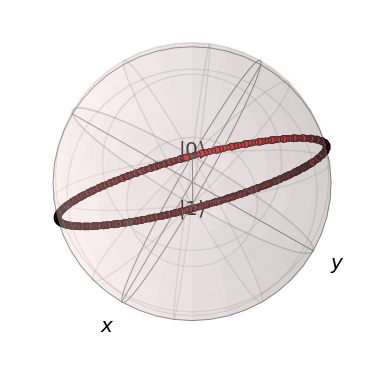

In [63]:
#plot_all(guess_dynamics, ϕ)
plot_evolution(guess_dynamics, steps=5)

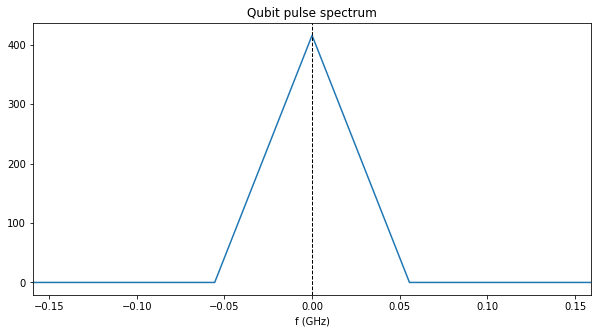

In [64]:
qubit_pulses = [H[1][1](t, 0) for t in tlist]
#qubit_pulses_filtered = apply_spectral_filter(copy.deepcopy(qubit_pulses), tlist, 0, 0.5)
plot_spectrum(qubit_pulses, tlist, mark_freq=[0, -K_q, -K_q/2], pos=0, xlim=[-1,1])
#plot_spectrum(qubit_pulses_filtered, tlist, mark_freq=[0, K_q], pos=0, xlim=[-2*K_q,2*K_q])
#plot_pulse(qubit_pulses, tlist)
#plot_pulse(qubit_pulses_filtered, tlist)
#plot_spectrum(qubit_pulses[1], time_list, mark_freq=[ω_q, ω_q + K_q, ω_q - K_q], pos=0)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved.

The cell below carries out the optimization. It
requires, besides the
previously
defined optimization `objectives`, information
about the
optimization functional
$F$ (via `chi_constructor`) and the
propagation method that should be used. In
addition, the number of total
iterations is required and, as an option, we pass
an info-hook that after each
iteration combines a complete printout of the state
of the optimization with the
`print_fidelity` function defined above.

Here, we
choose $F = F_{re}$ with
\begin{equation}
F_{re}
=
\Re\Braket{\Psi(T)}{\Psi_{\tgt}}
\end{equation}

with
$\ket{\Psi(T)}$ the
forward propagated state of $\ket{\Psi_{\init}}$.

In [259]:
pulse_options = {H_i[1]: dict(lambda_a=5, shape=S_funs[i]) for i, H_i in enumerate(H[1:])}

In [504]:
ω_0 = 0
ω_1 = np.abs(K_q/2)

In [513]:
def F_oc(fw_states_T, objectives, tau_vals=None, **kwargs):
    return np.abs(krotov.functionals.f_tau(fw_states_T, objectives, tau_vals, **kwargs))**2

def calc_fidelity(tau_vals):
    return np.abs(np.sum(tau_vals)/len(tau_vals))**2

def print_fidelity(**args):
    fid = calc_fidelity(np.array(args['tau_vals']))
    print("          F_t = {} | F = {} | F_t - F = {}".format(F_oc_tar, fid, F_oc_tar-fid))
def plot_fid_convergence(info_vals):
    fig, ax = plt.subplots(1,1)
    ax.plot(info_vals)
    ax.set_xticks(np.arange(0, len(info_vals), step=1))
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Fidelity')
    #ax.set_ylim((-0.2,.2))
    plt.show()
def modify_params(**kwargs):
    
    spectral_filtering = True
    
    if spectral_filtering:
        # Spectral filtering
        tlist = kwargs['tlist']
        dt = tlist[1] - tlist[0]  # assume equi-distant time grid
        n = len(tlist) - 1  # = len(pulse)
        # remember that pulses are defined on intervals of tlist
        ω = np.abs(np.fft.fftfreq(n, d=dt / (2.0 * π)))
        # the normalization factor 2π means that w0 and w1 are angular
        # frequencies, corresponding directly to energies in the Hamiltonian
        # (ħ = 1).
        flt = (ω_0 <= ω) * (ω <= ω_1)
        # flt is the (boolean) filter array, equivalent to an array of values 0
        # and 1 

        shape_arrays = kwargs['shape_arrays']
        for (i, (pulse, shape)) in enumerate(zip(kwargs['optimized_pulses'], shape_arrays)):
            spectrum = np.fft.fft(pulse)
            # apply the filter by element-wise multiplication
            spectrum[:] *= flt[:]
            # after the inverse fft, we should also multiply with the
            # update shape function. Otherwise, there is no guarantee that
            # the filtered pulse will be zero at t=0 and t=T (assuming that
            # is what the update shape is supposed to enforce). Also, it is
            # important that we overwrite `pulse` in-place (pulse[:] = ...)
            kwargs['optimized_pulses'][i][:] = np.fft.ifft(spectrum).real * shape
    
    # Limit pulse amplitude to 1 and smoothen
    for i in range(len(kwargs['optimized_pulses'])):
        conv = 3*σ
        if (conv % 2 == 0): conv += 1
        kwargs['optimized_pulses'][i] = savgol_filter(kwargs['optimized_pulses'][i], conv, 2)
        #kwargs['optimized_pulses'][i] = savgol_filter(kwargs['optimized_pulses'][i], 9, 2)
        pulse_max = np.max(np.abs(kwargs['optimized_pulses'][i]))
        if pulse_max > amp_max:
            kwargs['optimized_pulses'][i] = amp_max*kwargs['optimized_pulses'][i]/pulse_max
        if kwargs['iteration'] % 5 == 0:
            plot_pulse(kwargs['optimized_pulses'][i], kwargs['tlist'][:-1], kwargs['tlist'][-1])
            plot_spectrum(kwargs['optimized_pulses'][i], kwargs['tlist'][:-1], mark_freq=[0, -K_q, -K_q/2], mark_color=['r','g','b'], pos=0, xlim=[-(2*π), (2*π)])
    # Update λ
    fac = 1
    steps = 5
    λₐ = kwargs['lambda_vals'][0]
    for i in range(len(kwargs['lambda_vals'])):
        kwargs['lambda_vals'][i] = λₐ * fac
        lambda_a = λₐ * fac
    print("λₐ = {}".format(kwargs['lambda_vals']))


In [514]:
# Reset results
opt_result = None

In [515]:
def convergence_reason(opt_result):
    if opt_result == None:
        return True
    reasons = ['monotonic', 'iterations']
    for r in reasons:
        if opt_result.message.find(r)>0:
            return r
    if opt_result.message.find('F_oc')>0 or opt_result.message.find('Δ')>0:
        return False

In [516]:
from datetime import datetime
def current_time():
    return datetime.now().isoformat()[:16].replace('T',' ')

In [517]:
def run_optim(T, lambda_a):
    opt_result = None
    print('T = {}'.format(T))
    steps = 500
    tlist = np.linspace(0, T, steps)
    H = hamiltonian(ampl0=1, use_rotating=True, start_pulse=start_pulse, T=T, phase=np.exp(-1j*ω_q*T))
    
    #S_start = [start_pulse,start_pulse]
    S_funs = [S, S]
    for i, H_i in enumerate(H[1:]):
        H_i[1] = shape_field(H_i[1], S_funs[i], T, σ)
        plot_pulse(H_i[1], tlist)
    
    if use_rotating:
        objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in state_rot(ϕ, T)]
    else:
        objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in ϕ]
    
    # Check if guess pulse realises
    guess_dynamics = [ob.mesolve(tlist, options=qutip.Options(nsteps=50000)) for ob in objectives]
    final_state = guess_dynamics[0].states[-1]
    dm = final_state * ϕ[0][1].dag()
    fid = np.abs((final_state.dag() * ϕ[0][1]).full()[0][0])**2
    if fid > F_oc_tar:
        print('Guess pulse realises transfer already.')
        return True
    
    pulse_options = {H_i[1]: dict(lambda_a=lambda_a, shape=lambda t: S_funs[i](t, T)) for i, H_i in enumerate(H[1:])}
    while convergence_reason(opt_result):
        if convergence_reason(opt_result) == 'monotonic':
            break
            #lambda_a *= 2
        #    print('λₐ = {}'.format(lambda_a))
        #    pulse_options = {H_i[1]: dict(lambda_a=lambda_a, shape=lambda t: S_funs[i](t, T)) for i, H_i in enumerate(H[1:])}
        #iters = 5
        #if opt_result is not None:
        #    iters = opt_result.iters[-1] + iters

        opt_result = krotov.optimize_pulses(
            objectives,
            pulse_options=pulse_options,
            tlist=tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=krotov.functionals.chis_ss,
            info_hook=krotov.info_hooks.chain(
                krotov.info_hooks.print_table(J_T=F_oc),
                print_fidelity
            ),
            check_convergence=krotov.convergence.Or(
                krotov.convergence.value_above(F_oc_tar, name='F_oc'),
                krotov.convergence.delta_below(F_err*1e-1),
                #krotov.convergence.check_monotonic_fidelity,
            ),
            modify_params_after_iter = modify_params,
            #iter_stop=1,
            continue_from = opt_result,
        )
        print(opt_result.message)
    opt_result.dump(os.path.join(os.getcwd(),'results','{}_pi_pulse_optim_{}.dat'.format(current_time(),T)))

T = 36


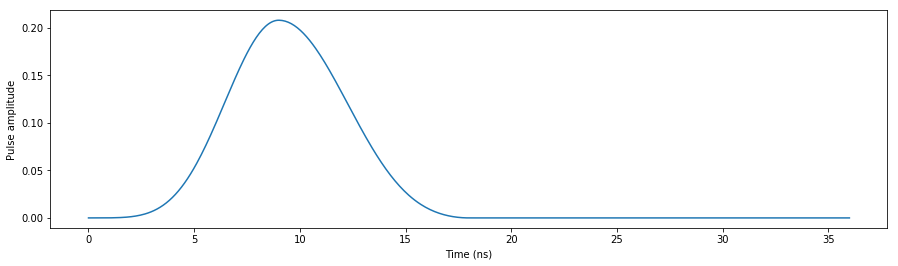

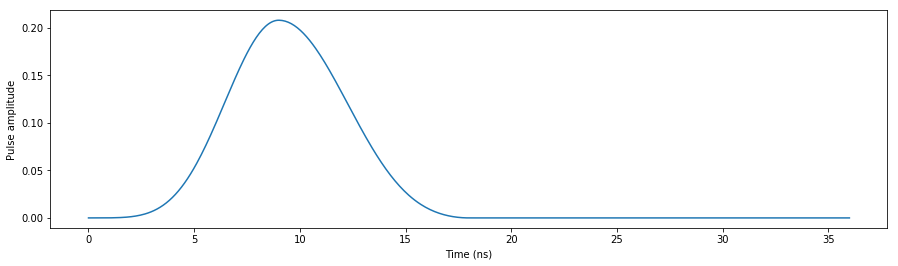

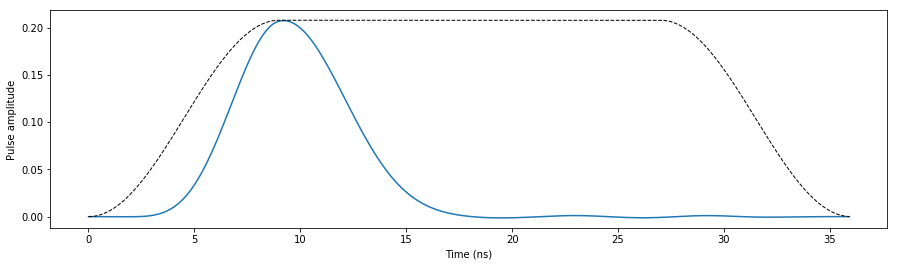

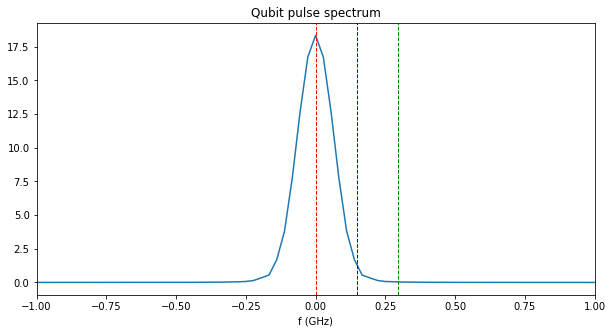

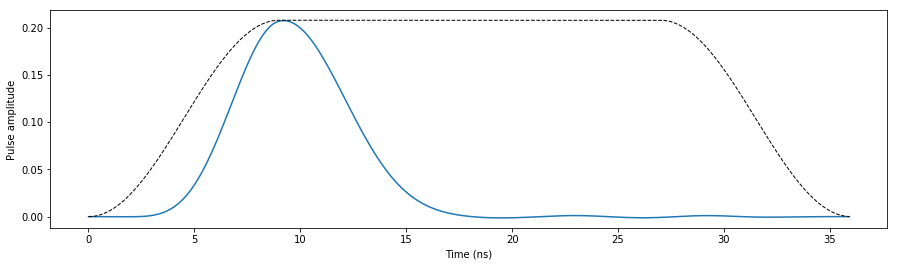

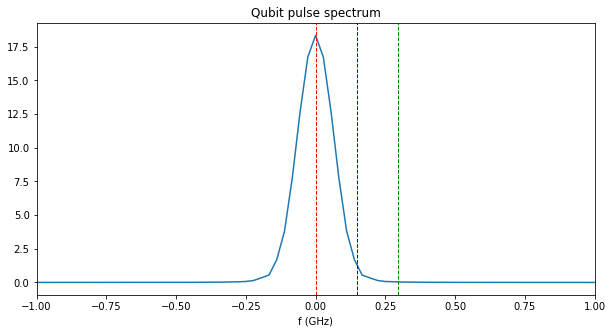

λₐ = [24.0642274 24.0642274]
  iter.        J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
      0   8.76e-01    0.00e+00   8.76e-01        n/a        n/a     0
          F_t = 0.999999 | F = 0.8756031895257029 | F_t - F = 0.12439581047429704
λₐ = [24.0642274 24.0642274]
      1   9.69e-01    3.58e-03   9.73e-01   9.34e-02   9.69e-02     2 **
          F_t = 0.999999 | F = 0.9689619990615204 | F_t - F = 0.03103700093847961
λₐ = [24.0642274 24.0642274]
      2   9.83e-01    2.29e-03   9.85e-01   1.42e-02   1.65e-02     2 **
          F_t = 0.999999 | F = 0.9831393109016205 | F_t - F = 0.016859689098379427
λₐ = [24.0642274 24.0642274]
      3   9.89e-01    1.48e-03   9.91e-01   6.14e-03   7.62e-03     2 **
          F_t = 0.999999 | F = 0.9892835070422291 | F_t - F = 0.010715492957770856
λₐ = [24.0642274 24.0642274]
      4   9.93e-01    9.91e-04   9.94e-01   3.55e-03   4.54e-03     2 **
          F_t = 0.999999 | F = 0.9928344379920476 | F_t - F = 0.0071645620079523464


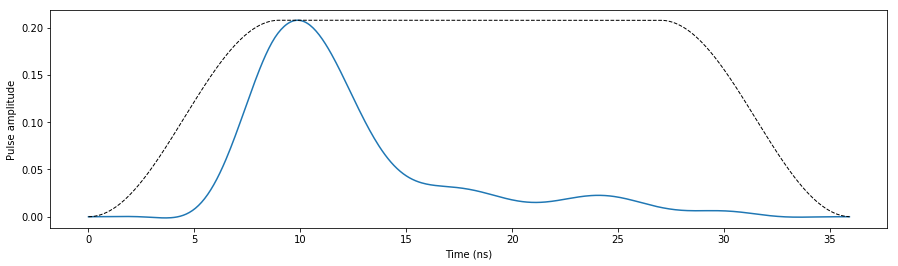

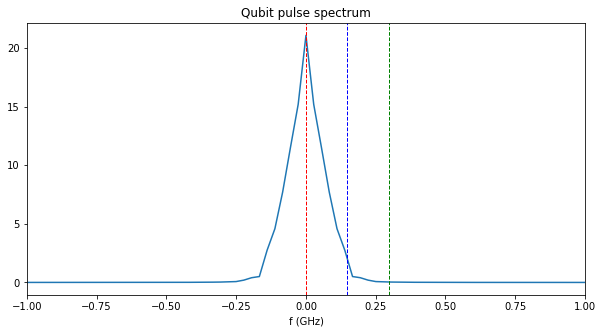

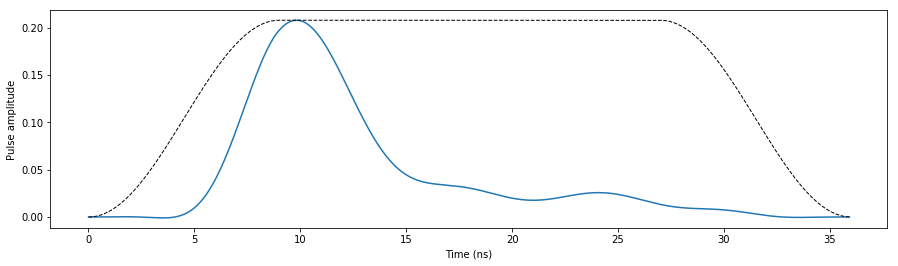

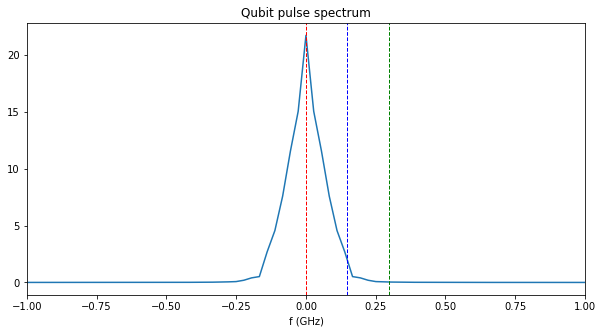

λₐ = [24.0642274 24.0642274]
      5   9.95e-01    6.92e-04   9.96e-01   2.16e-03   2.85e-03     2 **
          F_t = 0.999999 | F = 0.9949949086375744 | F_t - F = 0.005004091362425522
λₐ = [24.0642274 24.0642274]
      6   9.96e-01    5.02e-04   9.97e-01   1.38e-03   1.88e-03     2 **
          F_t = 0.999999 | F = 0.9963713301227831 | F_t - F = 0.0036276698772168547
λₐ = [24.0642274 24.0642274]
      7   9.97e-01    3.75e-04   9.98e-01   9.21e-04   1.30e-03     2 **
          F_t = 0.999999 | F = 0.9972926227858174 | F_t - F = 0.0027063772141825426
λₐ = [24.0642274 24.0642274]
      8   9.98e-01    2.88e-04   9.98e-01   6.36e-04   9.24e-04     2 **
          F_t = 0.999999 | F = 0.9979288836483474 | F_t - F = 0.002070116351652551
λₐ = [24.0642274 24.0642274]
      9   9.98e-01    2.26e-04   9.99e-01   4.53e-04   6.79e-04     2 **
          F_t = 0.999999 | F = 0.9983820655317349 | F_t - F = 0.0016169344682650522


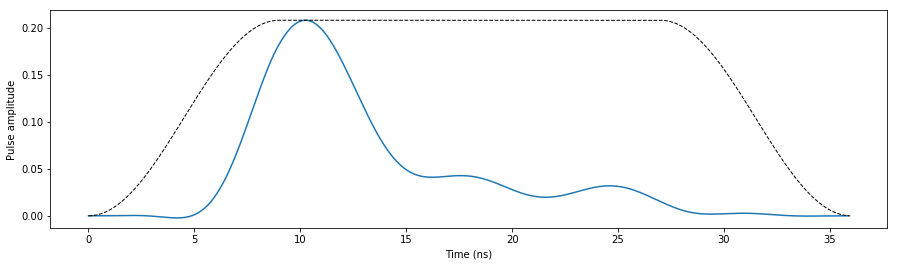

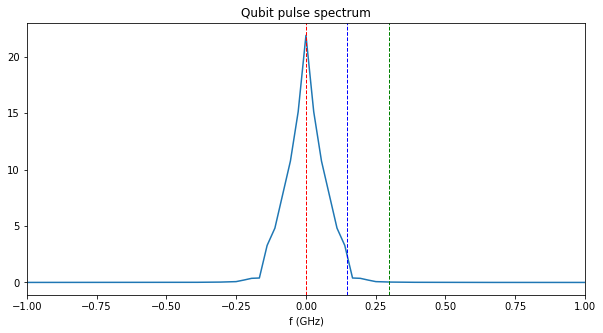

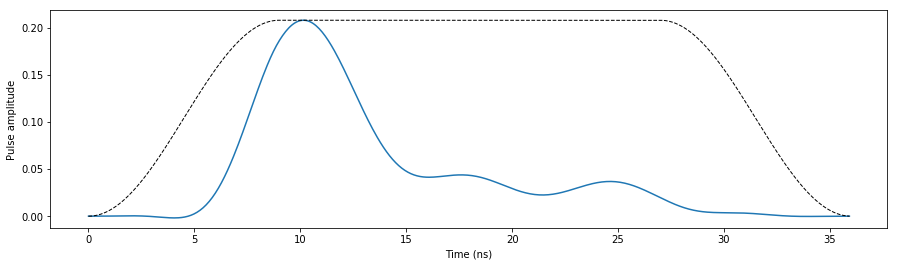

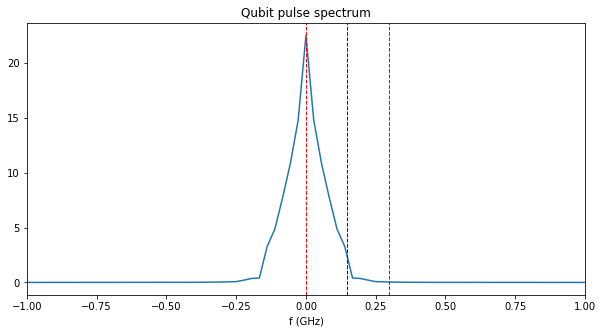

λₐ = [24.0642274 24.0642274]
     10   9.99e-01    1.81e-04   9.99e-01   3.33e-04   5.13e-04     2 **
          F_t = 0.999999 | F = 0.9987146140745685 | F_t - F = 0.0012843859254314527
λₐ = [24.0642274 24.0642274]
     11   9.99e-01    1.46e-04   9.99e-01   2.51e-04   3.98e-04     2 **
          F_t = 0.999999 | F = 0.9989661091145526 | F_t - F = 0.001032890885447335
λₐ = [24.0642274 24.0642274]
     12   9.99e-01    1.19e-04   9.99e-01   1.94e-04   3.13e-04     2 **
          F_t = 0.999999 | F = 0.9991604249559425 | F_t - F = 0.000838575044057488
λₐ = [24.0642274 24.0642274]
     13   9.99e-01    9.82e-05   9.99e-01   1.51e-04   2.49e-04     2 **
          F_t = 0.999999 | F = 0.9993115250679956 | F_t - F = 0.0006874749320043838
λₐ = [24.0642274 24.0642274]
     14   9.99e-01    8.15e-05   1.00e+00   1.19e-04   2.01e-04     2 **
          F_t = 0.999999 | F = 0.9994308875601355 | F_t - F = 0.0005681124398644322


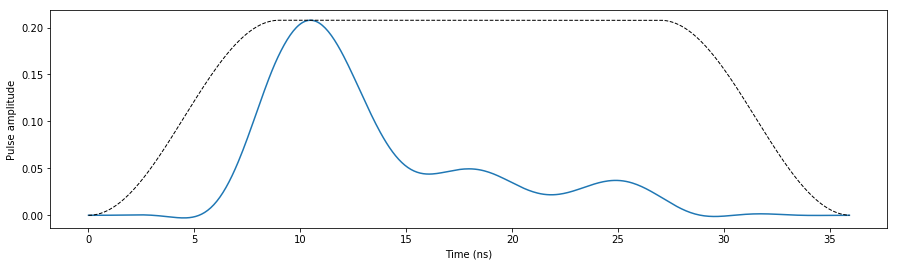

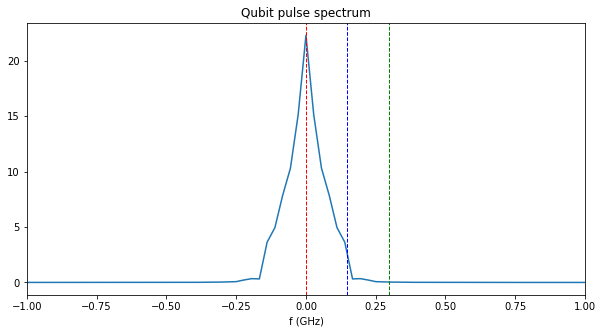

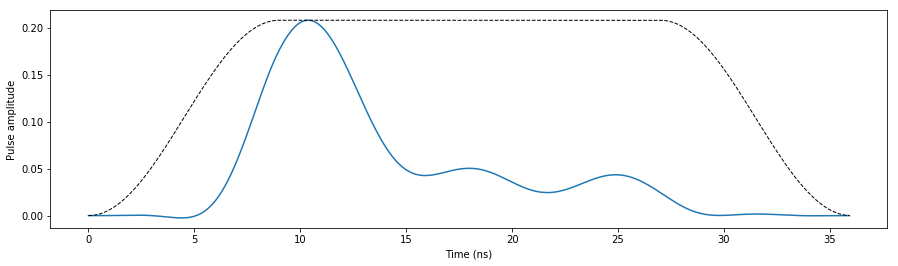

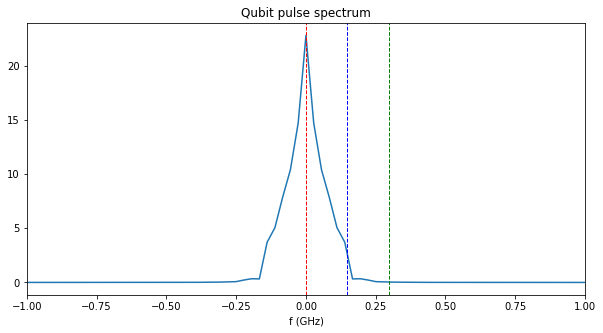

λₐ = [24.0642274 24.0642274]
     15   1.00e+00    6.77e-05   1.00e+00   9.76e-05   1.65e-04     2 **
          F_t = 0.999999 | F = 0.9995285330565379 | F_t - F = 0.00047046694346208895
λₐ = [24.0642274 24.0642274]
     16   1.00e+00    5.65e-05   1.00e+00   7.89e-05   1.35e-04     2 **
          F_t = 0.999999 | F = 0.9996074705797267 | F_t - F = 0.0003915294202733177
λₐ = [24.0642274 24.0642274]
     17   1.00e+00    4.72e-05   1.00e+00   6.51e-05   1.12e-04     2 **
          F_t = 0.999999 | F = 0.9996726097702032 | F_t - F = 0.0003263902297967469
λₐ = [24.0642274 24.0642274]
     18   1.00e+00    3.95e-05   1.00e+00   5.36e-05   9.32e-05     2 **
          F_t = 0.999999 | F = 0.9997262555489144 | F_t - F = 0.00027274445108560474
λₐ = [24.0642274 24.0642274]
     19   1.00e+00    3.32e-05   1.00e+00   4.43e-05   7.75e-05     2 **
          F_t = 0.999999 | F = 0.9997705896382912 | F_t - F = 0.00022841036170873075


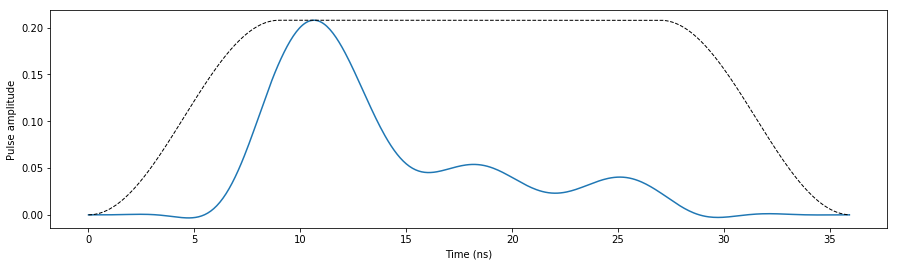

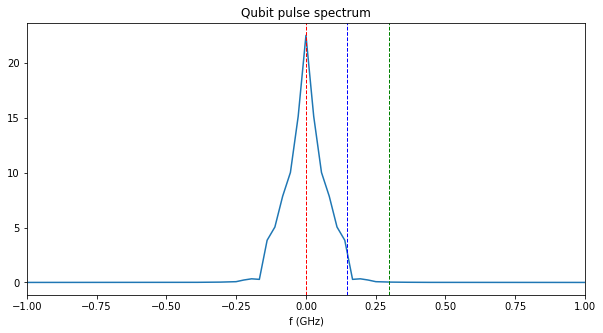

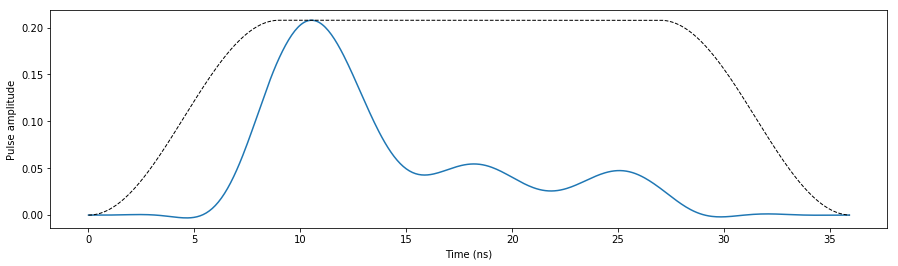

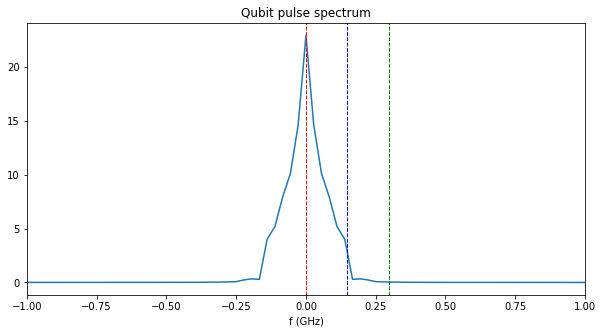

λₐ = [24.0642274 24.0642274]
     20   1.00e+00    2.77e-05   1.00e+00   3.74e-05   6.51e-05     2 **
          F_t = 0.999999 | F = 0.9998079736962953 | F_t - F = 0.00019102630370471108
λₐ = [24.0642274 24.0642274]
     21   1.00e+00    2.33e-05   1.00e+00   3.11e-05   5.43e-05     2 **
          F_t = 0.999999 | F = 0.9998390307478485 | F_t - F = 0.00015996925215144842
λₐ = [24.0642274 24.0642274]
     22   1.00e+00    1.96e-05   1.00e+00   2.53e-05   4.48e-05     2 **
          F_t = 0.999999 | F = 0.9998642890476287 | F_t - F = 0.00013471095237127528
λₐ = [24.0642274 24.0642274]
     23   1.00e+00    1.64e-05   1.00e+00   2.19e-05   3.83e-05     2 **
          F_t = 0.999999 | F = 0.9998862140826881 | F_t - F = 0.00011278591731189724
λₐ = [24.0642274 24.0642274]
     24   1.00e+00    1.38e-05   1.00e+00   1.79e-05   3.17e-05     2 **
          F_t = 0.999999 | F = 0.9999040927876662 | F_t - F = 9.490721233373911e-05


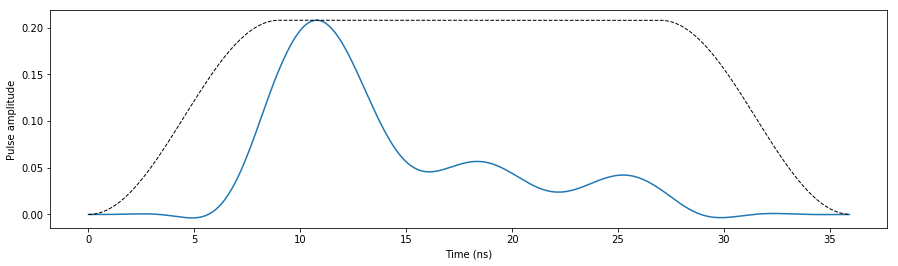

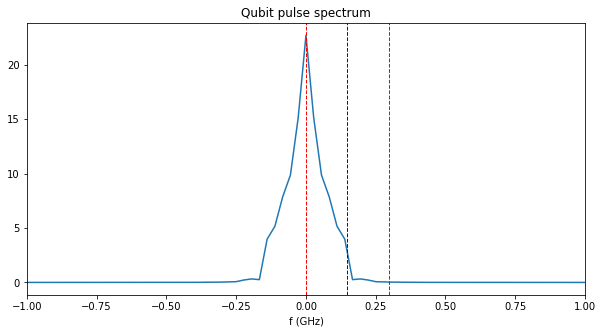

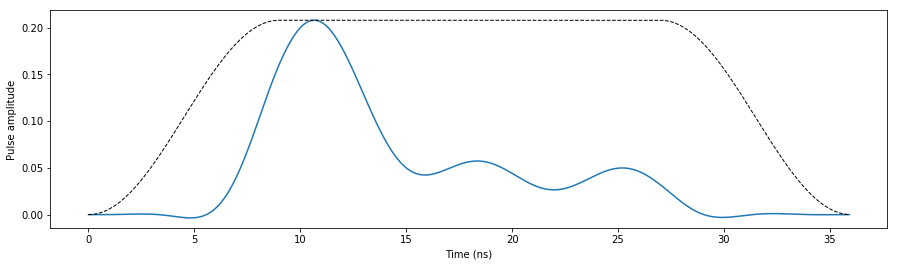

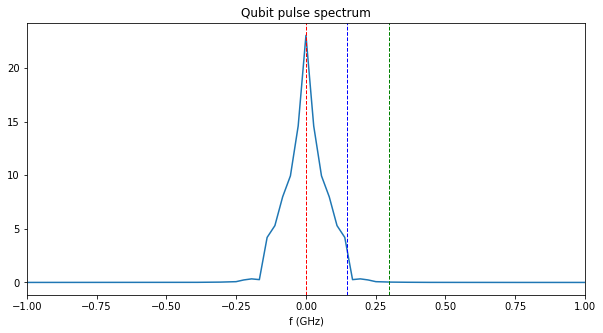

λₐ = [24.0642274 24.0642274]
     25   1.00e+00    1.16e-05   1.00e+00   1.53e-05   2.69e-05     2 **
          F_t = 0.999999 | F = 0.9999193578262168 | F_t - F = 7.964217378320093e-05
λₐ = [24.0642274 24.0642274]
     26   1.00e+00    9.70e-06   1.00e+00   1.30e-05   2.27e-05     2 **
          F_t = 0.999999 | F = 0.9999323836066052 | F_t - F = 6.661639339478054e-05
λₐ = [24.0642274 24.0642274]
     27   1.00e+00    8.17e-06   1.00e+00   1.05e-05   1.87e-05     2 **
          F_t = 0.999999 | F = 0.9999429119411396 | F_t - F = 5.6088058860370715e-05
λₐ = [24.0642274 24.0642274]
     28   1.00e+00    6.88e-06   1.00e+00   8.85e-06   1.57e-05     2 **
          F_t = 0.999999 | F = 0.9999517575656146 | F_t - F = 4.724243438536391e-05
λₐ = [24.0642274 24.0642274]
     29   1.00e+00    5.73e-06   1.00e+00   7.90e-06   1.36e-05     2 **
          F_t = 0.999999 | F = 0.9999596562817461 | F_t - F = 3.9343718253870286e-05


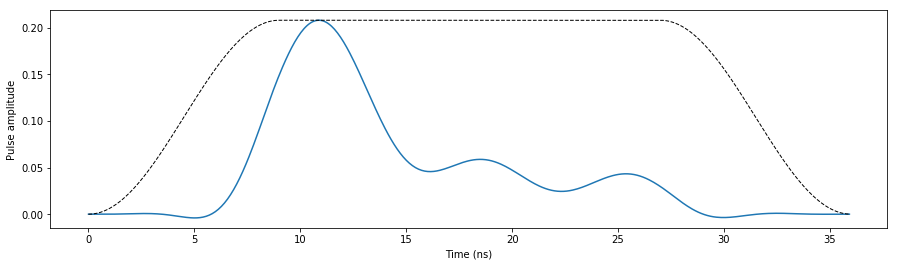

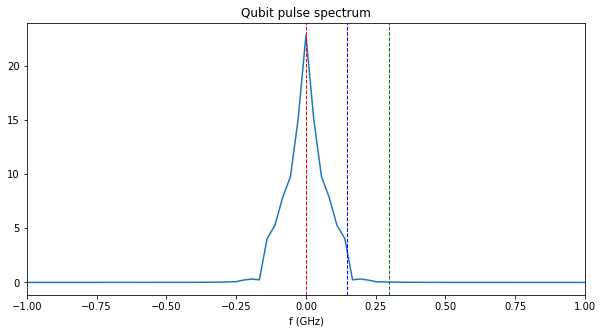

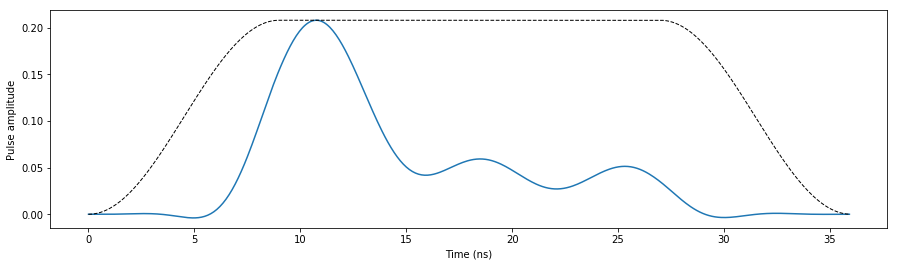

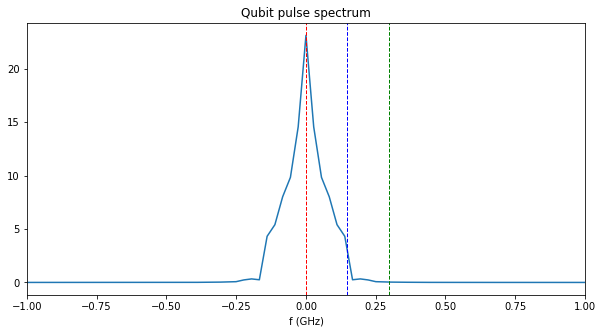

λₐ = [24.0642274 24.0642274]
     30   1.00e+00    4.82e-06   1.00e+00   6.38e-06   1.12e-05     2 **
          F_t = 0.999999 | F = 0.9999660375231445 | F_t - F = 3.296247685546927e-05
λₐ = [24.0642274 24.0642274]
     31   1.00e+00    4.11e-06   1.00e+00   4.84e-06   8.95e-06     2 **
          F_t = 0.999999 | F = 0.9999708774468784 | F_t - F = 2.812255312156786e-05
λₐ = [24.0642274 24.0642274]
     32   1.00e+00    3.52e-06   1.00e+00   4.20e-06   7.71e-06     2 **
          F_t = 0.999999 | F = 0.9999750736115772 | F_t - F = 2.392638842274586e-05
λₐ = [24.0642274 24.0642274]
     33   1.00e+00    3.02e-06   1.00e+00   3.54e-06   6.57e-06     2 **
          F_t = 0.999999 | F = 0.9999786171924544 | F_t - F = 2.0382807545571424e-05
λₐ = [24.0642274 24.0642274]
     34   1.00e+00    2.62e-06   1.00e+00   2.95e-06   5.57e-06     2 **
          F_t = 0.999999 | F = 0.9999815687056413 | F_t - F = 1.7431294358716265e-05


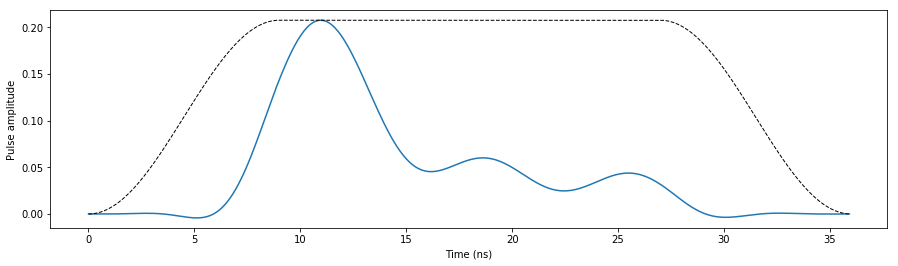

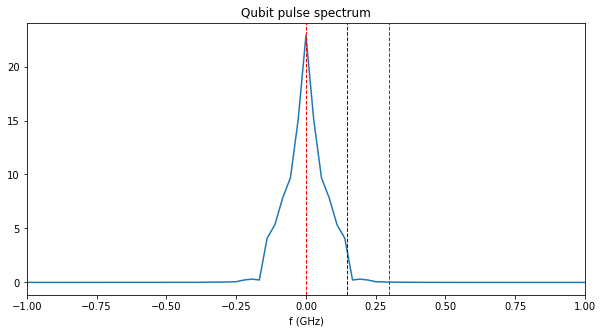

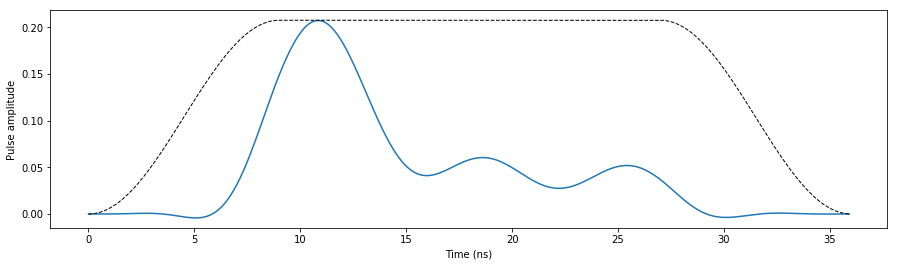

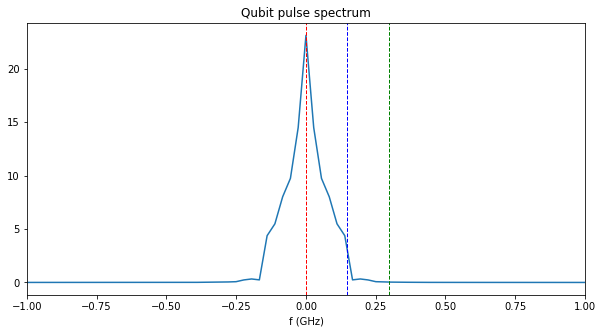

λₐ = [24.0642274 24.0642274]
     35   1.00e+00    2.36e-06   1.00e+00   1.93e-06   4.29e-06     2 **
          F_t = 0.999999 | F = 0.9999834952743988 | F_t - F = 1.550472560118976e-05
λₐ = [24.0642274 24.0642274]
     36   1.00e+00    2.10e-06   1.00e+00   1.91e-06   4.01e-06     2 **
          F_t = 0.999999 | F = 0.9999854033970035 | F_t - F = 1.3596602996490681e-05
λₐ = [24.0642274 24.0642274]
     37   1.00e+00    1.92e-06   1.00e+00   1.38e-06   3.30e-06     2 **
          F_t = 0.999999 | F = 0.9999867876787135 | F_t - F = 1.2212321286453331e-05
λₐ = [24.0642274 24.0642274]
     38   1.00e+00    1.77e-06   1.00e+00   1.10e-06   2.86e-06     2 **
          F_t = 0.999999 | F = 0.9999878829417368 | F_t - F = 1.1117058263176993e-05
λₐ = [24.0642274 24.0642274]
     39   1.00e+00    1.65e-06   1.00e+00   9.06e-07   2.55e-06     2 **
          F_t = 0.999999 | F = 0.9999887887692593 | F_t - F = 1.0211230740631017e-05


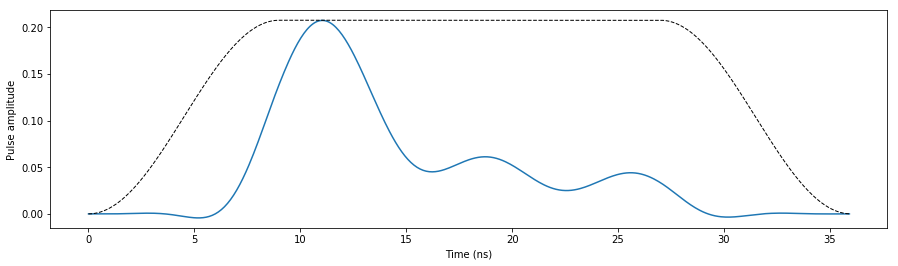

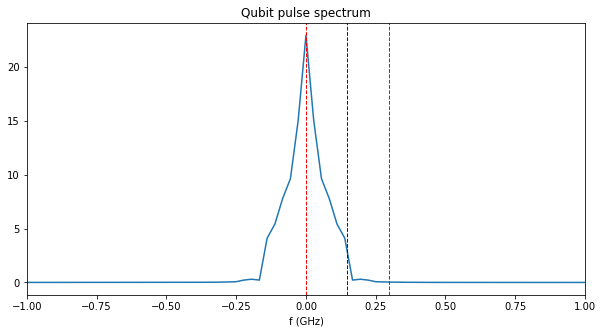

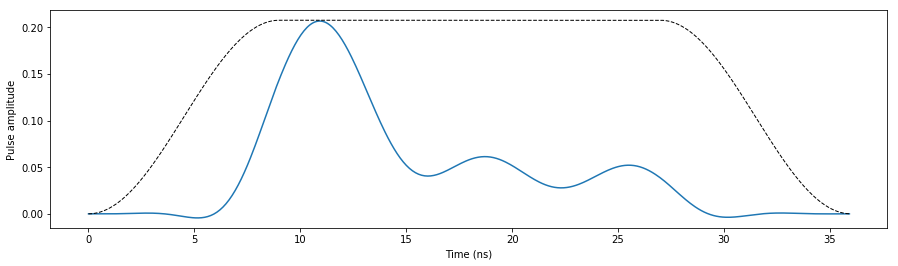

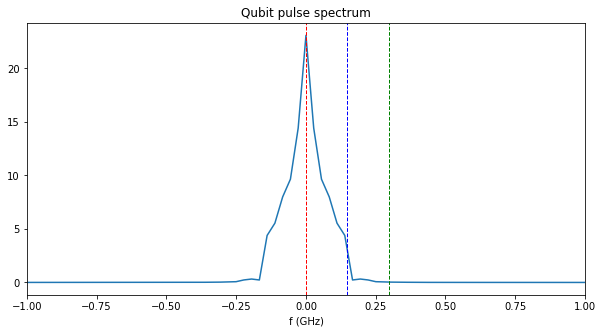

λₐ = [24.0642274 24.0642274]
     40   1.00e+00    1.54e-06   1.00e+00   7.67e-07   2.31e-06     2 **
          F_t = 0.999999 | F = 0.9999895556416201 | F_t - F = 9.444358379906426e-06
λₐ = [24.0642274 24.0642274]
     41   1.00e+00    1.45e-06   1.00e+00   6.58e-07   2.11e-06     2 **
          F_t = 0.999999 | F = 0.9999902140029242 | F_t - F = 8.785997075766439e-06
λₐ = [24.0642274 24.0642274]
     42   1.00e+00    1.37e-06   1.00e+00   5.71e-07   1.94e-06     2 **
          F_t = 0.999999 | F = 0.999990784541166 | F_t - F = 8.21545883400443e-06
λₐ = [24.0642274 24.0642274]
     43   1.00e+00    1.30e-06   1.00e+00   4.98e-07   1.80e-06     2 **
          F_t = 0.999999 | F = 0.9999912824228884 | F_t - F = 7.717577111598928e-06
λₐ = [24.0642274 24.0642274]
     44   1.00e+00    1.24e-06   1.00e+00   4.37e-07   1.68e-06     2 **
          F_t = 0.999999 | F = 0.999991719320118 | F_t - F = 7.280679881982444e-06


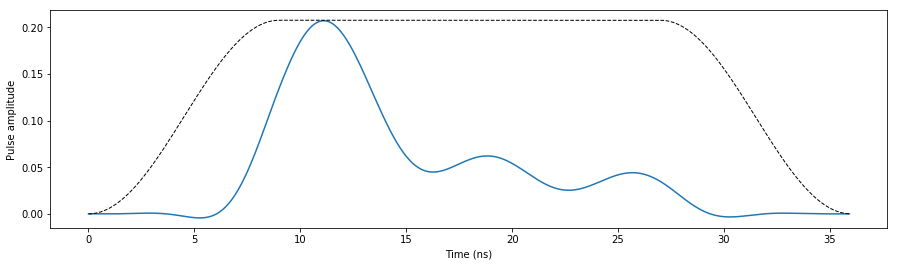

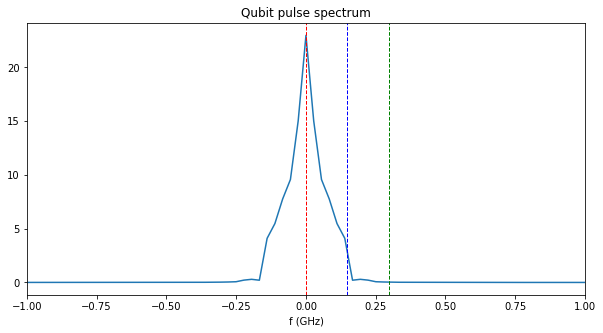

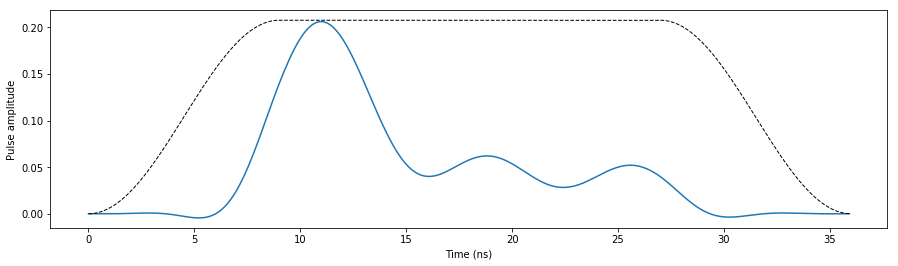

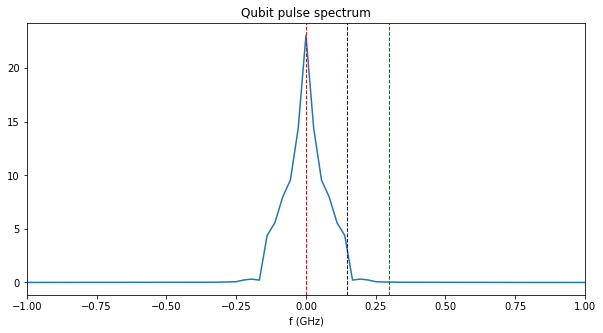

λₐ = [24.0642274 24.0642274]
     45   1.00e+00    1.19e-06   1.00e+00   3.85e-07   1.57e-06     2 **
          F_t = 0.999999 | F = 0.9999921045107768 | F_t - F = 6.895489223168738e-06
λₐ = [24.0642274 24.0642274]
     46   1.00e+00    1.14e-06   1.00e+00   3.41e-07   1.48e-06     2 **
          F_t = 0.999999 | F = 0.9999924455366446 | F_t - F = 6.554463355401552e-06
λₐ = [24.0642274 24.0642274]
     47   1.00e+00    1.10e-06   1.00e+00   3.03e-07   1.40e-06     2 **
          F_t = 0.999999 | F = 0.9999927486267314 | F_t - F = 6.251373268595373e-06
λₐ = [24.0642274 24.0642274]
     48   1.00e+00    1.06e-06   1.00e+00   2.70e-07   1.33e-06     2 **
          F_t = 0.999999 | F = 0.999993018986098 | F_t - F = 5.981013901923404e-06
λₐ = [24.0642274 24.0642274]
     49   1.00e+00    1.02e-06   1.00e+00   2.42e-07   1.27e-06     2 **
          F_t = 0.999999 | F = 0.999993261002317 | F_t - F = 5.738997682969149e-06


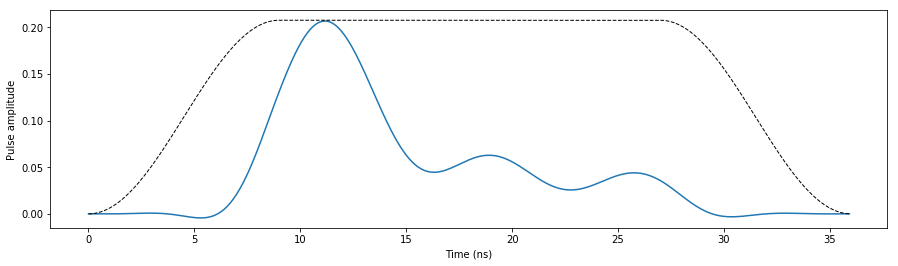

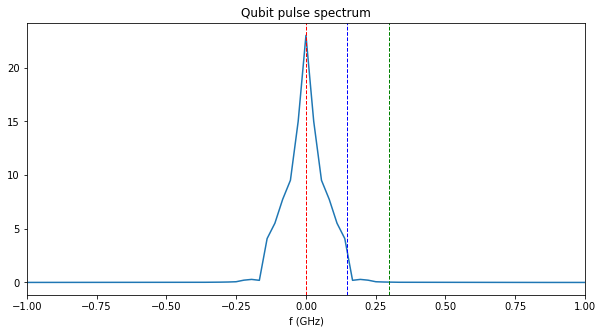

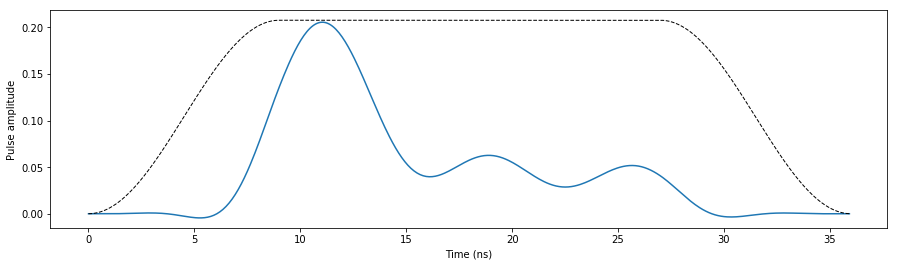

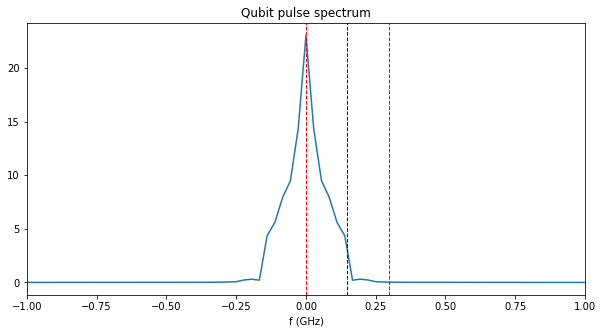

λₐ = [24.0642274 24.0642274]
     50   1.00e+00    9.93e-07   1.00e+00   2.17e-07   1.21e-06     2 **
          F_t = 0.999999 | F = 0.9999934783987807 | F_t - F = 5.5216012192493835e-06
λₐ = [24.0642274 24.0642274]
     51   1.00e+00    9.65e-07   1.00e+00   1.96e-07   1.16e-06     2 **
          F_t = 0.999999 | F = 0.9999936743521408 | F_t - F = 5.32564785915568e-06
λₐ = [24.0642274 24.0642274]
     52   1.00e+00    9.40e-07   1.00e+00   1.77e-07   1.12e-06     2 **
          F_t = 0.999999 | F = 0.9999938515843388 | F_t - F = 5.148415661127004e-06
λₐ = [24.0642274 24.0642274]
     53   1.00e+00    9.16e-07   1.00e+00   1.61e-07   1.08e-06     2 **
          F_t = 0.999999 | F = 0.99999401243623 | F_t - F = 4.987563769986991e-06
λₐ = [24.0642274 24.0642274]
     54   1.00e+00    8.95e-07   1.00e+00   1.46e-07   1.04e-06     2 **
          F_t = 0.999999 | F = 0.9999941589272058 | F_t - F = 4.841072794192769e-06


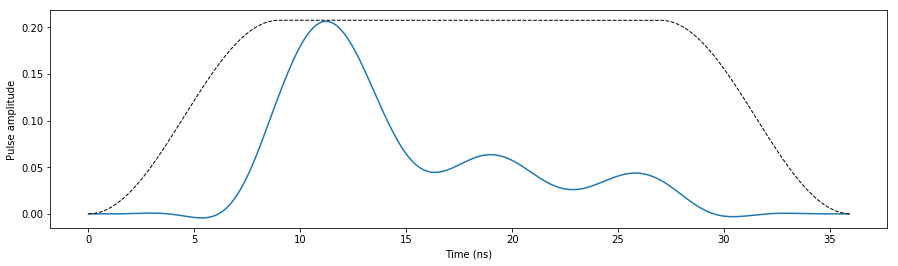

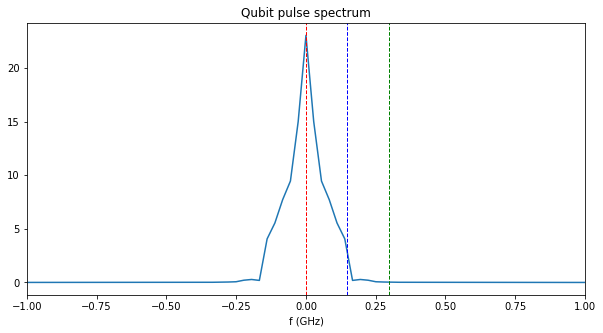

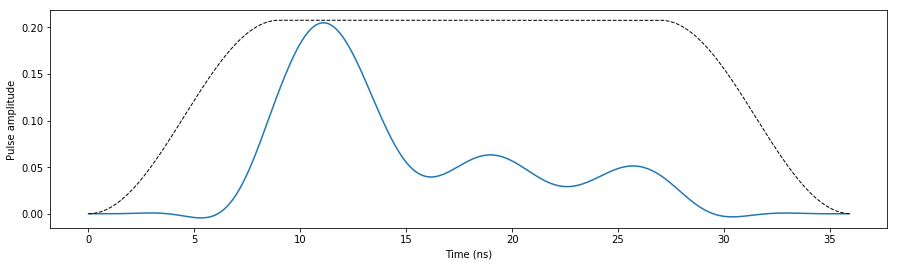

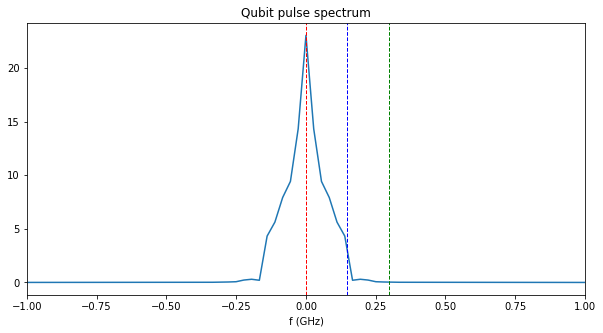

λₐ = [24.0642274 24.0642274]
     55   1.00e+00    8.76e-07   1.00e+00   1.34e-07   1.01e-06     2 **
          F_t = 0.999999 | F = 0.99999429280398 | F_t - F = 4.707196019970716e-06
λₐ = [24.0642274 24.0642274]
     56   1.00e+00    8.58e-07   1.00e+00   1.23e-07   9.81e-07     2 **
          F_t = 0.999999 | F = 0.9999944155812266 | F_t - F = 4.5844187733790065e-06
λₐ = [24.0642274 24.0642274]
     57   1.00e+00    8.42e-07   1.00e+00   1.13e-07   9.55e-07     2 **
          F_t = 0.999999 | F = 0.9999945285751003 | F_t - F = 4.47142489967689e-06
λₐ = [24.0642274 24.0642274]
     58   1.00e+00    8.27e-07   1.00e+00   1.04e-07   9.31e-07     2 **
          F_t = 0.999999 | F = 0.9999946329315947 | F_t - F = 4.367068405231045e-06
λₐ = [24.0642274 24.0642274]
     59   1.00e+00    8.13e-07   1.00e+00   9.67e-08   9.09e-07     2 **
          F_t = 0.999999 | F = 0.9999947296502859 | F_t - F = 4.270349714063926e-06
Reached convergence: Δ(('info_vals', T[-1]),('info_vals', T[-2])) < 1e-0

In [518]:
step_size = amp_max*0.2
λ = 1/step_size
for tot in [6*σ*2]:
    run_optim(tot, λ)

## Simulate dynamics of the optimized field

Having obtained the optimized
control field, we can now
plot it and calculate the
population dynamics under
this field.

In [ ]:
[plot_pulse(c, tlist) for c in opt_result.optimized_controls];

In [ ]:
plot_pulse(np.abs(opt_result.optimized_controls[0]+1j*opt_result.optimized_controls[1]), tlist)
plot_pulse(np.angle(opt_result.optimized_controls[0]+1j*opt_result.optimized_controls[1]), tlist)

In contrast to the dynamics under the guess field, the optimized field indeed
drives the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target
state $\ket{\Psi_{\tgt}} = \ket{1}$.

In [ ]:
opt_dynamics = [ob.mesolve(tlist, progress_bar=True) for ob in opt_result.optimized_objectives]

In [ ]:
qubit_occupation(opt_dynamics[0])

In [ ]:
plot_evolution(opt_dynamics)
#plot_all(opt_dynamics, ϕ)

# Simulate dynamics in lab frame

In [ ]:
#rotating_pulses = [np.vectorize(H_i[1])(tlist, None) for H_i in H[1:]]
rotating_pulses = oct_result.optimized_controls

tlist2 = np.linspace(0, T, int(np.ceil(200*T/T_q)))
Ω = rotating_pulses[0]+1j*rotating_pulses[1]
Ω = np.interp(tlist2, tlist, Ω)
pulses_lab = [Ω*np.exp(1j*ω_q*tlist2), np.conj(Ω)*np.exp(-1j*ω_q*tlist2)]
H_lab = hamiltonian(ω=1.0, ampl0=1, use_rotating=False, pulses=pulses_lab)
objectives_lab = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H_lab) for ψ in ϕ]
opt_dynamics_lab = [ob.mesolve(tlist2, progress_bar=True, options=qutip.Options(nsteps=50000)) for ob in objectives_lab]

In [ ]:
plot_pulse(Ω, tlist2)
[plot_pulse(p, tlist2) for p in pulses_lab];

In [ ]:
qubit_occupation(opt_dynamics_lab[0])
#plot_evolution(opt_dynamics_lab)

In [ ]:
plot_cardinal([opt_dynamics_lab[0].states[0]])
plot_cardinal([opt_dynamics_lab[0].states[-1]])

# Frequency analysis

In [ ]:
qubit_pulses = pulses_lab
time_list = tlist2

In [ ]:
qubit_pulses = opt_result.optimized_controls
time_list = tlist

In [44]:
def plot_spectrum(pulse, tlist, mark_freq=None, pos=1, xlim=None, mark_color=['k','k','k']):
    samples = len(tlist)
    sample_interval = tlist[-1]/samples
    time = np.linspace(0, samples*sample_interval, samples)

    signal_qubit = pulse
    signal_spectrum = np.fft.fftshift(np.fft.fft(signal_qubit))
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=sample_interval))

    plt.figure(figsize=(10,5))
    plt.plot(freqs, np.abs(signal_spectrum))  # in GHz
    if mark_freq is not None:
        if not isinstance(mark_freq, list):
            mark_freq = [mark_freq]
        mf = np.array(mark_freq)/(2*π)
        if pos==1:
            plt.xlim(0, 2*mf[0])
        elif pos==-1:
            plt.xlim(-2*mf[0], 0)
        elif xlim is not None:
            plt.xlim(xlim[0]/(2*π), xlim[1]/(2*π))
        [plt.axvline(x=m_f, ymin=0, ymax=1, color=col, linestyle='--', linewidth=1) for (m_f, col) in zip(mf,mark_color)]
    plt.title('Qubit pulse spectrum')
    plt.xlabel('f (GHz)');
    plt.show();

plot_spectrum(qubit_pulses[0], time_list, mark_freq=[ω_q, ω_q + K_q, ω_q - K_q], pos=1)
plot_spectrum(qubit_pulses[1], time_list, mark_freq=[ω_q, ω_q + K_q, ω_q - K_q], pos=-1)

NameError: name 'time_list' is not defined